# Deep learning basics: a simple classification case
In this tutorial, we train a Multi Layer Perceptron (MLP) on a binary classification task. Our goal is to determine the class of the data points based on their position in the following Cartesian grid. 

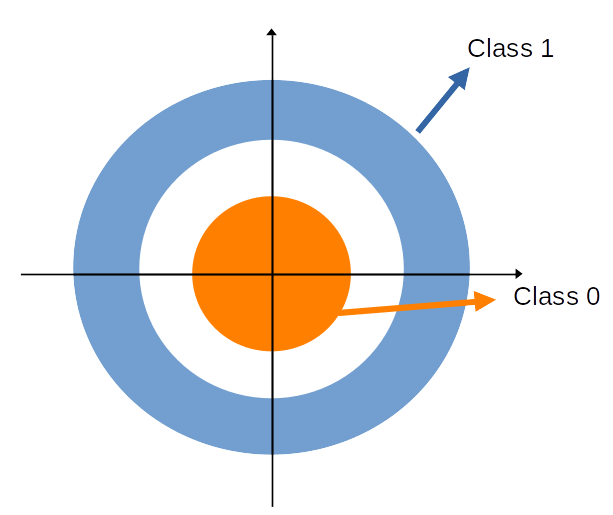

## Step 1: Prepare the environment

In [ ]:
import torch
import numpy as np
import pandas as pd
import plotly.express as px
from utils import plot_binary_class_predictions

In [ ]:
# Define computing device
use_cuda = True

if torch.cuda.is_available() and use_cuda:
    print('We have GPU !')
    device = torch.device('cuda')
else:
    print('We will use CPU')
    device = torch.device('cpu')

In [ ]:
# Fix random seed for reproducibility
torch.manual_seed(0)

## Step 2: Generate training data

In [ ]:
# Training data
radius = 5
r = torch.rand(1000)
angle = torch.rand(1000) * 2 * np.pi
# Class 0
r[:500] *= radius * 0.5
# Class 1
r[500:] *= radius * 0.3
r[500:] += radius * 0.7

x_1 = r * torch.sin(angle)
x_2 = r * torch.cos(angle)
inputs = inputs = torch.stack((x_1, x_2), dim=1).to(device)

# Label
labels = torch.where(torch.sqrt(inputs[:, 0]**2 + inputs[:, 1]**2) < (radius * 0.5), 0., 1.).unsqueeze(1)

In [ ]:
training_data = pd.DataFrame(
    {
        'x': inputs[:, 0].flatten().to('cpu'),
        'y': inputs[:, 1].flatten().to('cpu'),
        'c': labels.to('cpu').flatten().type(torch.int).numpy().astype(str)
    }
)

In [ ]:
fig = px.scatter(training_data, x='x', y='y', color='c', color_discrete_map={'0': "blue", '1': "orange"})
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )

## Step 3: Build the neural network

We build a MLP, i.e., composed of Fully Connected layers, with 2 hidden layers. It is worth noticing that **a final Sigmoid** function transforms the model output into a probability to belong to the positive class (class 1).

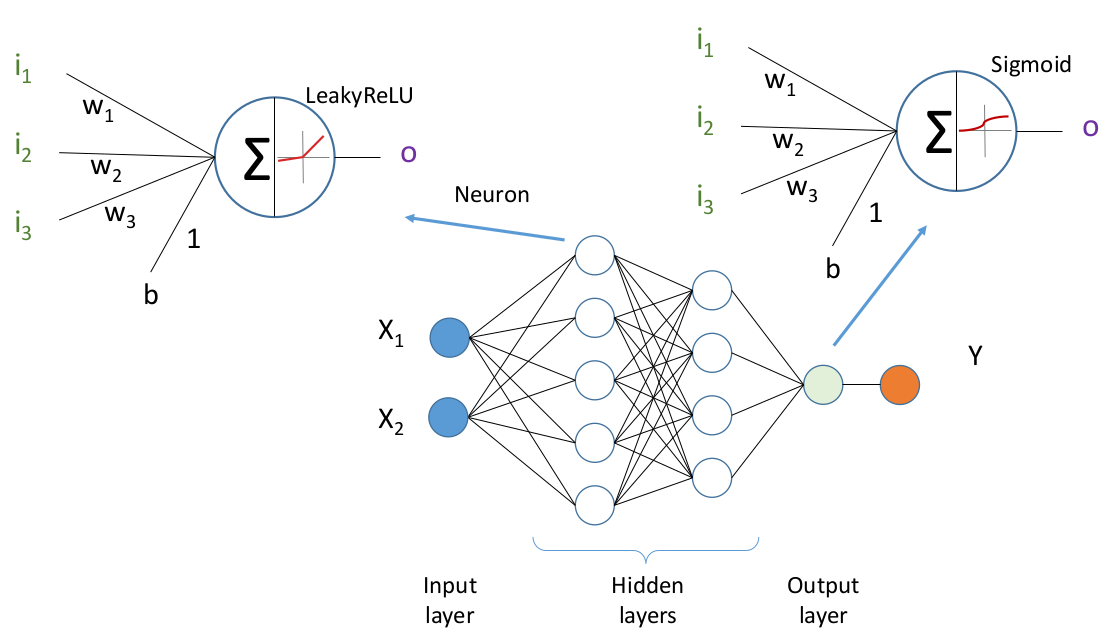

### Exercises
1. Complete the definition of the following neural network. The model should be composed of 2 hidden layers (fully connected ones). Fill the missing code and set the number of neurons of each layer.
2. Find the minimal number of neurons for each layer offering satisfying performance on the task we're trying to solve, i.e., test accuracy > 0.99

In [ ]:
# Fix random seed for reproducibility
torch.manual_seed(0)

In [ ]:
neurons_lin1 = ?
neurons_lin2 = ?

model = torch.nn.Sequential(
    # hidden layers
    torch.nn.Linear(in_features=inputs.shape[1], out_features=neurons_lin1),
    torch.nn.LeakyReLU(),
    ?
    ?
    
    # output layers
    torch.nn.Linear(in_features= ? , out_features=labels.shape[1]),
    torch.nn.Sigmoid()
)

model.to(device)

## Step 4: Define training hyperparameters

In [ ]:
# Loss function
criterion = torch.nn.BCELoss()

# Optimizer (Gradient descent)
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100

## Step 5: Train the network

In [ ]:
predictions = []
losses = []

for epoch in range(num_epochs):
    # Reinitialize gradient of the model weights
    optimizer.zero_grad()
    
    # Prediction
    y_pred = model(inputs)
    
    # Error measurement
    loss = criterion(y_pred, labels)
    
    # Backpropagation
    loss.backward()
    
    # Weight update
    optimizer.step()
    
    predictions.append(y_pred.detach().to('cpu'))
    losses.append(loss.detach().to('cpu'))

### Training results

In [ ]:
training_loss = pd.DataFrame({
    'Epoch': range(len(losses)),
    'Loss': losses
})

In [ ]:
fig = px.line(training_loss, x='Epoch', y='Loss', title='Training loss')
fig.show()

In [ ]:
plot_binary_class_predictions(training_data, predictions)

## Step 6: Test the model on new data

In [ ]:
# Test data
radius = 5
r_test = torch.rand(1400)
angle_test = torch.rand(1400) * 2 * np.pi
# Class 0
r_test[:700] *= radius * 0.5
# Class 1
r_test[700:] *= radius * 0.3
r_test[700:] += radius * 0.7

x_1_test = r_test * torch.sin(angle_test)
x_2_test = r_test * torch.cos(angle_test)
inputs_test = torch.cat((x_1_test.unsqueeze(1), x_2_test.unsqueeze(1)), dim=1).to(device)

# Label
labels_test = torch.where(torch.sqrt(inputs_test[:, 0]**2 + inputs_test[:, 1]**2) < (radius * 0.5), 0., 1.).unsqueeze(1)

In [ ]:
# Switch the model to test mode
# This is important for some kinds of layers, such as BatchNorm, that have 
# different behavior at test and training time
model.eval()

# We don't need to build the gradient graph, so let's save some memory !
with torch.no_grad():
    y_pred_test = model(inputs_test)
    test_loss = criterion(y_pred_test, labels_test)

In [ ]:
class_pred_test = y_pred_test.round()
accuracy_test = (class_pred_test == labels_test).float().mean()

In [ ]:
test_results = pd.DataFrame(
    {
        'x': x_1_test.to('cpu').flatten(),
        'y': x_2_test.to('cpu').flatten(),
        'class_pred': class_pred_test.to('cpu').flatten().type(torch.int).numpy().astype(str)
    }
)

In [ ]:
fig = px.scatter(test_results, x='x', y='y', color='class_pred', color_discrete_map={'0': "blue", '1': "orange"},
                title='Test results. Test loss: {:0.4f} - Accuracy: {:0.4f}'.format(test_loss, accuracy_test))
fig.update_traces(marker={'size': 3})
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

## Do you need a "solution" ?
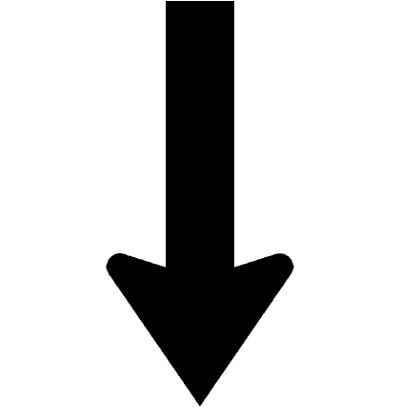

### Hint

Beware of the number of inputs of the second hidden layer.

### Solution
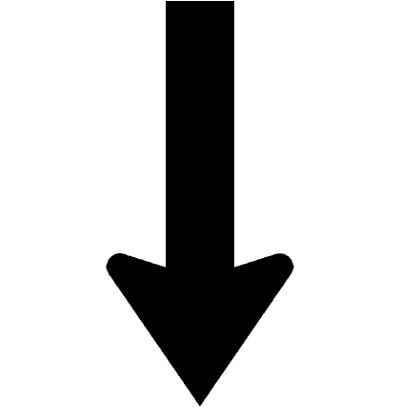

In [ ]:
# Model definition
neurons_lin1 = 4
neurons_lin2 = 2

model = torch.nn.Sequential(
    # hidden layers
    torch.nn.Linear(inputs.shape[1], neurons_lin1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(neurons_lin1, neurons_lin2),
    torch.nn.LeakyReLU(),
    # output layers
    torch.nn.Linear(neurons_lin2, labels.shape[1]),
    torch.nn.Sigmoid()
)
